### Import and Set up

In [1]:
import numpy as np
import torch
import torchvision
import detectron2
import cv2
import os
import json
import random

In [2]:
print(torch.__version__, torch.cuda.is_available())

1.10.1 True


In [3]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
# import some common detectron2 utilities
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
#choose which category to train on
category = "text"

### Prepare Dataset (only certain category)
Convert VOC xml files into a COCO json format file via VOC2COCO package

In [6]:
register_coco_instances("newspapers",{},"/home/students/s121md105_05/newspaper/zhangchi/old_newpaper_project_2122/VOC2COCO/output_new_"+category+".json","../21S1_URECA_FYP/ST2020-01")
register_coco_instances("newspapers_test",{},"/home/students/s121md105_05/newspaper/zhangchi/old_newpaper_project_2122/VOC2COCO/output_new_"+category+"_test.json","../21S1_URECA_FYP/ST2020-01")

In [7]:
newspapers_metadata = MetadataCatalog.get("newspapers")

In [8]:
newspapers_dataset_dicts = DatasetCatalog.get("newspapers")

[02/23 15:17:35 d2.data.datasets.coco]: Loaded 79 images in COCO format from /home/students/s121md105_05/newspaper/zhangchi/old_newpaper_project_2122/VOC2COCO/output_new_text.json


In [9]:
len(newspapers_dataset_dicts)

79

In [10]:
#visualize current pictures
import matplotlib.pyplot as plt

### Setting up the model
We use a Faster RCNN model with a Resnet 50 backbone

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("newspapers",)
cfg.DATASETS.TEST = ("newspapers_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name) 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 500    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [12]:
trainer.train()

[02/09 12:38:13 d2.engine.train_loop]: Starting training from iteration 0


/home/students/s121md105_05/anaconda3/envs/ureca/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/students/s121md105_05/anaconda3/envs/ureca/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180544224/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/09 12:38:18 d2.utils.events]:  eta: 0:01:48  iter: 19  total_loss: 2.872  loss_cls: 1.672  loss_box_reg: 0.1263  loss_rpn_cls: 0.8283  loss_rpn_loc: 0.1027  time: 0.2251  data_time: 0.0131  lr: 9.7405e-06  max_mem: 2306M
[02/09 12:38:22 d2.utils.events]:  eta: 0:01:42  iter: 39  total_loss: 2.623  loss_cls: 1.55  loss_box_reg: 0.3052  loss_rpn_cls: 0.5994  loss_rpn_loc: 0.1331  time: 0.2235  data_time: 0.0028  lr: 1.9731e-05  max_mem: 2306M
[02/09 12:38:27 d2.utils.events]:  eta: 0:01:37  iter: 59  total_loss: 2.151  loss_cls: 1.284  loss_box_reg: 0.5613  loss_rpn_cls: 0.1674  loss_rpn_loc: 0.1  time: 0.2238  data_time: 0.0053  lr: 2.972e-05  max_mem: 2306M
[02/09 12:38:31 d2.utils.events]:  eta: 0:01:33  iter: 79  total_loss: 1.982  loss_cls: 1.007  loss_box_reg: 0.7326  loss_rpn_cls: 0.09325  loss_rpn_loc: 0.1066  time: 0.2244  data_time: 0.0032  lr: 3.9711e-05  max_mem: 2306M
[02/09 12:38:36 d2.utils.events]:  eta: 0:01:29  iter: 99  total_loss: 1.796  loss_cls: 0.7909  loss_box

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [14]:
from detectron2.utils.visualizer import ColorMode
test_dicts = DatasetCatalog.get("newspapers_test")

[02/09 12:40:10 d2.data.datasets.coco]: Loaded 20 images in COCO format from /home/students/s121md105_05/newspaper/zhangchi/old_newpaper_project_2122/VOC2COCO/output_new_text_test.json


In [15]:
#print predictions
# for d in test_dicts:
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im)  
#     print(outputs)

In [16]:
#print visulazed prediction and save predictions as pictures
# count = 1
# for d in test_dicts:
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im) 
#     f = open('test_'+category+'/test_report.txt', "a")
#     f.write(d["file_name"]+'\n'+str(outputs)+'\n')
#     f.close()
#     v = Visualizer(im[:, :, ::-1],
#                    metadata=newspapers_metadata, 
#                    scale=1, 
#     )
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.imshow(out.get_image())
#     out.save('test_'+category+'/test_'+category+str(count)+'.png')
#     count += 1

In [56]:
import time
import shutil
from glob import glob



ModuleNotFoundError: No module named 'ocr'

In [59]:
# path_to_ocr_dir = '../phase2/ocr.pytorch-master/'
# #prepare ocr input
# for d in test_dicts:
#     im = cv2.imread(d["file_name"])
#     output = predictor(im)
#     prediction = output["instances"].to("cpu")
#     boxes = prediction.pred_boxes if prediction.has("pred_boxes") else None
#     scores = prediction.scores if prediction.has("scores") else None
#     boxes_array = boxes.tensor.numpy()
#     scores_array = scores.numpy()
#     centers = boxes.get_centers().numpy()
#     unsorted_boxes = []
#     for i in range(len(boxes_array)):
#         if scores_array[i]> 0.9:
#             box = {}
#             box['score'] = scores_array[i]
#             box['boundary'] = boxes_array[i]
#             box['center'] = centers[i]
#             unsorted_boxes.append(box)
#     sorted_boxes = sorted(unsorted_boxes, key=lambda d: (d['center'][0],d['center'][1]))
#     with open(path_to_ocr_dir+d["image_id"]+'_boxes.txt', 'w') as filehandle:
#         for listitem in sorted_boxes:
#             filehandle.write('%s\n' % listitem)

In [19]:
boxes[0].tensor[0].numpy()

array([1013.143 , 1258.3967, 1234.3386, 1836.6556], dtype=float32)

In [20]:
boxes[0].get_centers().numpy()[0]

array([1123.7408, 1547.5261], dtype=float32)

In [21]:
print(d)

{'file_name': '../21S1_URECA_FYP/ST2020-01/IMG_5841.PNG', 'height': 2048, 'width': 1536, 'image_id': 'IMG_5841', 'annotations': [{'iscrowd': 0, 'bbox': [50, 1066, 220, 782], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [290, 854, 225, 994], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [531, 1257, 220, 596], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [774, 1254, 217, 597], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1012, 1250, 217, 597], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1255, 297, 222, 1449], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


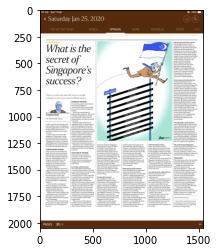

In [28]:
img = cv2.imread(d['file_name'])
plt.imshow(img)

1013
1258
1234
1837


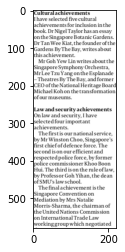

In [49]:
left = round(boxes[0].tensor[0].numpy()[0])
top = round(boxes[0].tensor[0].numpy()[1])
right = round(boxes[0].tensor[0].numpy()[2])
bottom = round(boxes[0].tensor[0].numpy()[3])
print(left)
print(top)
print(right)
print(bottom)
crop_img = img[top:bottom,left:right]
plt.imshow(crop_img)

In [43]:
scores.numpy()

array([0.9919029 , 0.9917663 , 0.9911197 , 0.99039906, 0.9844334 ,
       0.9707645 , 0.96469736, 0.9527983 , 0.9517708 , 0.9433359 ,
       0.9423925 , 0.9358466 , 0.9172517 , 0.87346894, 0.86286575,
       0.8117903 , 0.73809016, 0.7261084 , 0.6076255 , 0.5688549 ,
       0.56594855], dtype=float32)

In [42]:
scores[0].numpy()

array(0.9919029, dtype=float32)

In [46]:
boxes.get_centers().numpy()

array([[1123.7408 , 1547.5261 ],
       [ 406.01367, 1362.8889 ],
       [ 884.8187 , 1576.238  ],
       [ 640.971  , 1558.5009 ],
       [ 168.23502, 1425.5914 ],
       [1365.8657 ,  696.475  ],
       [ 243.75407,  815.2262 ],
       [ 407.12555, 1120.3987 ],
       [ 875.3329 , 1364.3895 ],
       [ 403.41644, 1639.8472 ],
       [1366.0146 , 1574.4656 ],
       [1369.6306 ,  951.5145 ],
       [ 643.04663, 1400.9995 ],
       [1121.9633 , 1379.1069 ],
       [1359.6411 , 1817.5682 ],
       [ 638.9175 , 1696.0592 ],
       [1358.5946 ,  479.37018],
       [ 165.86725, 1190.3672 ],
       [ 847.1572 ,  956.41736],
       [1365.3955 , 1311.1135 ],
       [1364.032  , 1152.0356 ]], dtype=float32)

In [47]:
boxes

Boxes(tensor([[1013.1430, 1258.3967, 1234.3386, 1836.6556],
        [ 289.3015,  882.5590,  522.7258, 1843.2189],
        [ 771.3987, 1296.8536,  998.2387, 1855.6224],
        [ 533.3854, 1268.7634,  748.5566, 1848.2383],
        [  50.8461, 1009.7640,  285.6239, 1841.4188],
        [1248.7957,  317.7155, 1482.9358, 1075.2345],
        [  45.6067,  788.7404,  441.9015,  841.7120],
        [ 288.9197,  880.2865,  525.3314, 1360.5107],
        [ 764.5521, 1259.7061,  986.1137, 1469.0730],
        [ 288.2177, 1432.8348,  518.6152, 1846.8595],
        [1251.0997, 1390.3710, 1480.9294, 1758.5602],
        [1251.4141,  111.5760, 1487.8472, 1791.4530],
        [ 536.1508, 1260.1472,  749.9424, 1541.8519],
        [1011.9997, 1262.4464, 1231.9269, 1495.7676],
        [1246.2693, 1779.4629, 1473.0128, 1855.6736],
        [ 527.1520, 1549.6486,  750.6829, 1842.4698],
        [1248.8467,  311.3928, 1468.3425,  647.3476],
        [  53.2514, 1062.3402,  278.4831, 1318.3942],
        [ 644.1796,  7

In [53]:
d = test_dicts[0]
im = cv2.imread(d["file_name"])
output = predictor(im)
prediction = output["instances"].to("cpu")
boxes = prediction.pred_boxes if prediction.has("pred_boxes") else None
scores = prediction.scores if prediction.has("scores") else None
boxes_array = boxes.tensor.numpy()
scores_array = scores.numpy()
centers = boxes.get_centers().numpy()
unsorted_boxes = []
for i in range(len(boxes_array)):
    if scores_array[i]> 0.9:
        box = {}
        box['score'] = scores_array[i]
        box['boundary'] = boxes_array[i]
        box['center'] = centers[i]
        unsorted_boxes.append(box)
sorted_boxes = sorted(unsorted_boxes, key=lambda d: (d['center'][0],d['center'][1]))


[{'score': 0.9844334,
  'boundary': array([  50.84611, 1009.764  ,  285.62393, 1841.4188 ], dtype=float32),
  'center': array([ 168.23502, 1425.5914 ], dtype=float32)},
 {'score': 0.96469736,
  'boundary': array([ 45.606693, 788.7404  , 441.90146 , 841.71204 ], dtype=float32),
  'center': array([243.75407, 815.2262 ], dtype=float32)},
 {'score': 0.9433359,
  'boundary': array([ 288.21768, 1432.8348 ,  518.6152 , 1846.8595 ], dtype=float32),
  'center': array([ 403.41644, 1639.8472 ], dtype=float32)},
 {'score': 0.9917663,
  'boundary': array([ 289.30154,  882.559  ,  522.7258 , 1843.2189 ], dtype=float32),
  'center': array([ 406.01367, 1362.8889 ], dtype=float32)},
 {'score': 0.9527983,
  'boundary': array([ 288.91968,  880.2865 ,  525.3314 , 1360.5107 ], dtype=float32),
  'center': array([ 407.12555, 1120.3987 ], dtype=float32)},
 {'score': 0.99039906,
  'boundary': array([ 533.3854 , 1268.7634 ,  748.55664, 1848.2383 ], dtype=float32),
  'center': array([ 640.971 , 1558.5009], dtype

In [60]:
d['file_name']

'../21S1_URECA_FYP/ST2020-01/IMG_5878.PNG'